In [1]:
!nvidia-smi --list-gpus

GPU 0: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-b3420b31-4832-b27f-df3a-6215a94894aa)


In [2]:
from tensorflow.python.client import device_lib
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version:", tf.__version__)
print(device_lib.list_local_devices())

Num GPUs Available:  1
Tensorflow version: 2.6.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4092123348763278229
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9398714368
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5447519129631472242
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:0b:00.0, compute capability: 7.5"
]


In [3]:
# If in colab
if "google.colab" in str(get_ipython()):
    %tensorflow_version 2.x

import glob
import itertools
import os
import random
import shutil
import warnings

from IPython.display import display

import tensorflow as tf
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow import keras
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,
    Flatten,
    MaxPool2D,
)
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

In [4]:
PATH_TO_ZIP = r"H:\Datasets\Kaggle\retinal_disease_classification\archive.zip"
PATH_UNZIP = r"H:\Datasets\Kaggle\retinal_disease_classification"

PATH_TO_SET_TRAINING = os.path.join(PATH_UNZIP, "Training_Set")
PATH_TO_SET_EVALUATION = os.path.join(PATH_UNZIP, "Evaluation_Set")
PATH_TO_SET_TEST = os.path.join(PATH_UNZIP, "Test_Set")

COLUMN_NAME_IMAGE_PATH = 'image_path'

BATCH_SIZE = 32

IMAGE_SIZE_VGG_16 = (244, 244)

In [5]:
# https://stackoverflow.com/questions/19124601/pretty-print-an-entire-pandas-series-dataframe
def print_df_full(x):
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    display(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

In [6]:
def plot_loss(history):
    plt.figure(figsize=(10,10))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 2])
    plt.xlabel('Epoch')
    plt.ylabel('Error [DX]')
    plt.legend()
    plt.grid(True)

#### Unzip files

In [7]:
import zipfile

if not os.path.exists(PATH_TO_SET_TRAINING):
    with zipfile.ZipFile(PATH_TO_ZIP, 'r') as zip_ref:
        zip_ref.extractall(PATH_UNZIP)

In [8]:
df_train_original = pd.read_csv(os.path.join(PATH_UNZIP, 'Training_Set/Training_Set/RFMiD_Training_Labels.csv'))
df_val_original = pd.read_csv(os.path.join(PATH_UNZIP, 'Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv'))
df_test_original = pd.read_csv(os.path.join(PATH_UNZIP, 'Test_Set/Test_Set/RFMiD_Testing_Labels.csv'))

In [9]:
df_train_original[COLUMN_NAME_IMAGE_PATH] = [os.path.join(
    PATH_UNZIP,
    f'Training_Set/Training_Set/Training/{id}.png') for id in df_train_original['ID']]

df_val_original[COLUMN_NAME_IMAGE_PATH] = [os.path.join(
    PATH_UNZIP,
    f'Evaluation_Set/Evaluation_Set/Validation/{id}.png') for id in df_val_original['ID']]

df_test_original[COLUMN_NAME_IMAGE_PATH] = [os.path.join(
    PATH_UNZIP,
    f'Test_Set/Test_Set/Test/{id}.png') for id in df_test_original['ID']]

In [10]:
df_train_original

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL,image_path
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...
1916,1917,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...
1917,1918,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...
1918,1919,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...


In [11]:
df_train_original[COLUMN_NAME_IMAGE_PATH][0]

'H:\\Datasets\\Kaggle\\retinal_disease_classification\\Training_Set/Training_Set/Training/1.png'

In [12]:
columns = list(df_train_original.columns)
columns.remove(COLUMN_NAME_IMAGE_PATH)
total_sum = 0

dict_df_temp = {}

for col in columns:
    # print(col)
    # print(df_train[col].value_counts())
    # print('----------------')
    if col != 'Disease_Risk':
        total_sum += df_train_original[col].sum()

    dict_df_temp[col] = {key: df_train_original[col].value_counts().get(key, 0) for key in range(2)}

    # print(list((df_train[col].value_counts())))
    # print(df_train[col].value_counts().to_dict())
    # print({key : value for key, value in df_train[col].value_counts().to_dict().items()})
    # print({key : df_train[col].value_counts().get(key, 0) for key in range(2)})


df_value_count = pd.DataFrame(dict_df_temp)

print_df_full(df_value_count)
print(f'{total_sum=}')

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,ODPM,PRH,MNF,HR,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,0,401,1544,1820,1603,1782,1819,1847,1734,1906,1873,1905,1883,1638,1892,1914,1904,1855,1862,1915,1903,1909,1906,1877,1888,1905,1898,1909,1914,1917,1919,1920,1918,1917,1920,1918,1917,1916,1915,1917,1919,1919,1919,1918,1919,1919,1919
1,1,1519,376,100,317,138,101,73,186,14,47,15,37,282,28,6,16,65,58,5,17,11,14,43,32,15,22,11,6,3,1,0,2,3,0,2,3,4,5,3,1,1,1,2,1,1,1


total_sum=1846229


In [13]:
COLUMNS_TO_DROP = [
    'ID',  # Don't need a ID column anymore
    'Disease_Risk',  #
    'ODPM',  # Zero Postive examples
    'HR'  # Zero Postive examples
]

df_train_model_1 = df_train_original.drop(labels=COLUMNS_TO_DROP, axis=1)
df_val_model_1 = df_val_original.drop(labels=COLUMNS_TO_DROP, axis=1)
df_test_model_1 = df_test_original.drop(labels=COLUMNS_TO_DROP, axis=1)

In [14]:
print_df_full(df_train_model_1.head())
print_df_full(df_val_model_1.head())
print_df_full(df_test_model_1.head())

,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,PRH,MNF,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL,image_path
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...
3,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...
4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...


,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,PRH,MNF,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL,image_path
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...


,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,PRH,MNF,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL,image_path
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...
2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H:\Datasets\Kaggle\retinal_disease_classificat...


In [15]:
print_df_full(df_train_model_1[COLUMN_NAME_IMAGE_PATH][0])
print_df_full(df_val_model_1[COLUMN_NAME_IMAGE_PATH][0])
print_df_full(df_test_model_1[COLUMN_NAME_IMAGE_PATH][0])

'H:\\Datasets\\Kaggle\\retinal_disease_classification\\Training_Set/Training_Set/Training/1.png'

'H:\\Datasets\\Kaggle\\retinal_disease_classification\\Evaluation_Set/Evaluation_Set/Validation/1.png'

'H:\\Datasets\\Kaggle\\retinal_disease_classification\\Test_Set/Test_Set/Test/1.png'

In [16]:
Y_train_columns = list(df_train_model_1.drop([COLUMN_NAME_IMAGE_PATH], axis=1).columns)
Y_val_columns = list(df_val_model_1.drop([COLUMN_NAME_IMAGE_PATH], axis=1).columns)
Y_test_columns = list(df_test_model_1.drop([COLUMN_NAME_IMAGE_PATH], axis=1).columns)

unq_disease = len(Y_train_columns)

In [17]:
print_df_full(pd.DataFrame([Y_train_columns, Y_val_columns, Y_test_columns]))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
0,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,PRH,MNF,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
1,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,PRH,MNF,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
2,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,PRH,MNF,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL


In [18]:
# plt.subplots(3, 4, figsize=(240, 160))

# for i in range(12):
#     plt.subplot(3, 4, i + 1)
#     image_path = df_train.iloc[i][-1]  # image_path is the last column in the df
#     img = mpimg.imread(image_path)
#     plt.imshow(img)

In [19]:
datagen_train_vgg_16_model_1 = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    # rescale=1./255,
    # horizontal_flip=True,
    # vertical_flip=True,
    # rotation_range=90,
    # brightness_range=[0, 0.1]
)

datagen_val_vgg_16_model_1 = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    # rescale=1./255
)

datagen_test_vgg_16_model_1 = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    # rescale=1./255
)

# The value for class_mode in flow_from_dataframe MUST be 'raw' if you are attempting to do multilabel classification.
gen_train_vgg_16_model_1 = datagen_train_vgg_16_model_1.flow_from_dataframe(
    df_train_model_1,
    x_col=COLUMN_NAME_IMAGE_PATH,
    y_col=Y_train_columns,
    target_size=IMAGE_SIZE_VGG_16,
    # target_size=(150, 150),
    # Treats values in columns as raw target types (you should make sure that the values in the columns are ints)
    # class_mode='raw',
    # batch_size=16,
    # shuffle=True
    # batch_size=8
    batch_size=BATCH_SIZE,
    class_mode='raw',

)

gen_val_vgg_16_model_1 = datagen_val_vgg_16_model_1.flow_from_dataframe(
    df_val_model_1,
    x_col=COLUMN_NAME_IMAGE_PATH,
    y_col=Y_val_columns,
    target_size=IMAGE_SIZE_VGG_16,
    # target_size=(150, 150),
    # Treats values in columns as raw target types (you should make sure that the values in the columns are ints)
    # class_mode='raw',
    # batch_size=8
    batch_size=BATCH_SIZE,
    class_mode='raw',
)

gen_test_vgg_16_model_1 = datagen_test_vgg_16_model_1.flow_from_dataframe(
    df_test_model_1,
    x_col=COLUMN_NAME_IMAGE_PATH,
    y_col=Y_test_columns,
    target_size=IMAGE_SIZE_VGG_16,
    # target_size=(150, 150),
    # Treats values in columns as raw target types (you should make sure that the values in the columns are ints)
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False,
)

Found 1920 validated image filenames.
Found 640 validated image filenames.
Found 640 validated image filenames.


### VGG 16

In [20]:
"""
Download vgg_16 model and import vgg_16 model
"""
model_vgg_16 = keras.applications.vgg16.VGG16()
model_vgg_16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [21]:
# CNN 1

In [22]:
"""
create a new model that will obtain the same layers as the vgg_16 model
"""

# New model
model_vgg_16_transfer_learning_1 = Sequential()

# Copy the layyers into the new model excluding the last layer because we want a custom prediction layer
for i in range(0, len(model_vgg_16.layers) - 1):
    layer = model_vgg_16.layers[i]
    model_vgg_16_transfer_learning_1.add(layer)

model_vgg_16_transfer_learning_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [23]:
"""
Don't train the copied layers from the vgg16 model in the new model because we are doing transfer learning.
Recall the last layer of the vgg16 model was predictions and it is not in this new model because we need to
add our own layer.
"""
for layer in model_vgg_16_transfer_learning_1.layers:
    layer.trainable = False

# Add new last layer
model_vgg_16_transfer_learning_1.add(Dense(len(Y_train_columns), activation="softmax"))

In [24]:
model_vgg_16_transfer_learning_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

## Training CNN 1

In [25]:
MULTIPLIER = 1

In [26]:
model_vgg_16_transfer_learning_1.compile(
    Adam(learning_rate=0.001 * MULTIPLIER),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [27]:

_steps_per_epoch = gen_train_vgg_16_model_1.samples // BATCH_SIZE
print(f'{_steps_per_epoch=}')

_validation_steps = gen_val_vgg_16_model_1.samples // BATCH_SIZE
print(f'{_validation_steps=}')

_steps_per_epoch=60
_validation_steps=20


In [28]:
%timeit
history_1 = model_vgg_16_transfer_learning_1.fit(
    gen_train_vgg_16_model_1,
    validation_data=gen_val_vgg_16_model_1,
    # batch_size=32 * MULTIPLIER,
    # steps_per_epoch=_steps_per_epoch,
    # validation_steps=_validation_steps,
    epochs=1,
    verbose=1,
    callbacks=[ReduceLROnPlateau()]
)

60/60 [==============================] - 184s 3s/step - loss: 3.1818 - accuracy: 0.3365 - val_loss: 2.9629 - val_accuracy: 0.3672


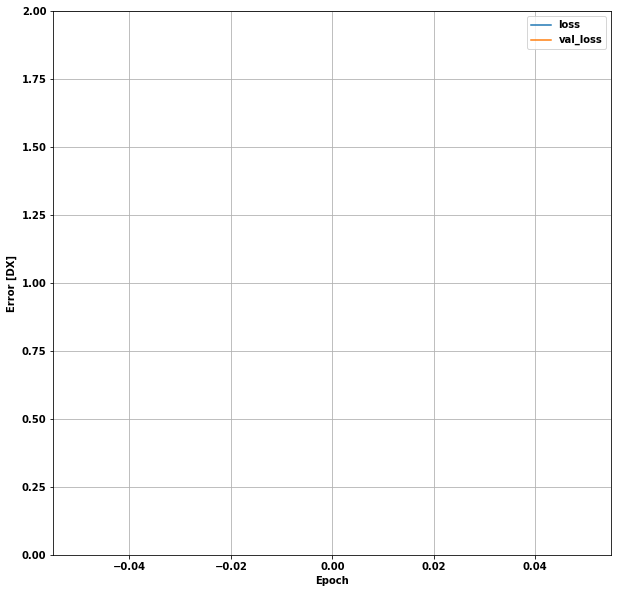

In [29]:
plot_loss(history_1)

# CNN 2 Prior stuff

In [30]:
COLUMNS_TO_HAVE = [
    'Disease_Risk',
    'image_path'
]

DICT_COLUMN_NAMES_NEW = {0: 'not_at_risk', 1: 'at_risk'}
COLUMN_NAMES_MODEL_2 = list(DICT_COLUMN_NAMES_NEW.values())

df_train_model_2 = df_train_original[COLUMNS_TO_HAVE]
df_val_model_2 = df_val_original[COLUMNS_TO_HAVE]
df_test_model_2 = df_test_original[COLUMNS_TO_HAVE]

df_train_model_2_onehot = pd.get_dummies(df_train_model_2['Disease_Risk'])
df_val_model_2_onehot = pd.get_dummies(df_val_model_2['Disease_Risk'])
df_test_model_2_onehot = pd.get_dummies(df_test_model_2['Disease_Risk'])

df_train_model_2 = pd.concat([df_train_model_2_onehot, df_train_model_2.drop(['Disease_Risk'], axis=1)], axis=1)
df_train_model_2 = df_train_model_2.rename(columns=DICT_COLUMN_NAMES_NEW)

df_val_model_2 = pd.concat([df_val_model_2_onehot, df_val_model_2.drop(['Disease_Risk'], axis=1)], axis=1)
df_val_model_2 = df_val_model_2.rename(columns=DICT_COLUMN_NAMES_NEW)

df_test_model_2 = pd.concat([df_test_model_2_onehot, df_test_model_2.drop(['Disease_Risk'], axis=1)], axis=1)
df_test_model_2 = df_test_model_2.rename(columns=DICT_COLUMN_NAMES_NEW)

In [31]:
# pd.concat([df_train_model_2, df_val_model_2, df_test_model_2], axis=1)
display(df_train_model_2)
display(df_val_model_2)
display(df_test_model_2)

,not_at_risk,at_risk,image_path
0,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
1,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
2,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
3,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
4,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
...,...,...,...
1915,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
1916,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
1917,1,0,H:\Datasets\Kaggle\retinal_disease_classificat...
1918,1,0,H:\Datasets\Kaggle\retinal_disease_classificat...


,not_at_risk,at_risk,image_path
0,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
1,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
2,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
3,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
4,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
...,...,...,...
635,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
636,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
637,1,0,H:\Datasets\Kaggle\retinal_disease_classificat...
638,1,0,H:\Datasets\Kaggle\retinal_disease_classificat...


,not_at_risk,at_risk,image_path
0,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
1,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
2,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
3,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
4,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
...,...,...,...
635,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
636,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
637,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...
638,0,1,H:\Datasets\Kaggle\retinal_disease_classificat...


In [32]:
Y_column_cnn_2 = COLUMN_NAMES_MODEL_2

In [33]:
datagen_train_vgg_16_model_2 = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    # rescale=1./255,
    # horizontal_flip=True,
    # vertical_flip=True,
    # rotation_range=90,
    # brightness_range=[0, 0.1]
)

datagen_val_vgg_16_model_2 = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    # rescale=1./255
)

datagen_test_vgg_16_model_2 = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    # rescale=1./255
)

# The value for class_mode in flow_from_dataframe MUST be 'raw' if you are attempting to do multilabel classification.
gen_train_vgg_16_model_2 = datagen_train_vgg_16_model_2.flow_from_dataframe(
    df_train_model_2,
    x_col=COLUMN_NAME_IMAGE_PATH,
    y_col=Y_column_cnn_2,
    target_size=IMAGE_SIZE_VGG_16,
    # target_size=(150, 150),
    # Treats values in columns as raw target types (you should make sure that the values in the columns are ints)
    # class_mode='raw',
    # batch_size=16,
    # shuffle=True
    # batch_size=8
    batch_size=BATCH_SIZE,
    class_mode='raw',

)

gen_val_vgg_16_model_2 = datagen_val_vgg_16_model_2.flow_from_dataframe(
    df_val_model_2,
    x_col=COLUMN_NAME_IMAGE_PATH,
    y_col=Y_column_cnn_2,
    target_size=IMAGE_SIZE_VGG_16,
    # target_size=(150, 150),
    # Treats values in columns as raw target types (you should make sure that the values in the columns are ints)
    # class_mode='raw',
    # batch_size=8
    batch_size=BATCH_SIZE,
    class_mode='raw',
)

gen_test_vgg_16_model_2 = datagen_test_vgg_16_model_2.flow_from_dataframe(
    df_test_model_2,
    x_col=COLUMN_NAME_IMAGE_PATH,
    y_col=Y_column_cnn_2,
    target_size=IMAGE_SIZE_VGG_16,
    # target_size=(150, 150),
    # Treats values in columns as raw target types (you should make sure that the values in the columns are ints)
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False,
)

Found 1920 validated image filenames.
Found 640 validated image filenames.
Found 640 validated image filenames.


# CNN 2 

In [34]:
"""
create a new model that will obtain the same layers as the vgg_16 model
"""

# New model
model_vgg_16_transfer_learning_2 = Sequential()

# Copy the layyers into the new model excluding the last layer because we want a custom prediction layer
for i in range(0, len(model_vgg_16.layers) - 1):
    layer = model_vgg_16.layers[i]
    model_vgg_16_transfer_learning_2.add(layer)

model_vgg_16_transfer_learning_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [35]:
"""
Don't train the copied layers from the vgg16 model in the new model because we are doing transfer learning.
Recall the last layer of the vgg16 model was predictions and it is not in this new model because we need to
add our own layer.
"""
for layer in model_vgg_16_transfer_learning_2.layers:
    layer.trainable = False

# Add new last layer
model_vgg_16_transfer_learning_2.add(Dense(len(Y_column_cnn_2), activation="softmax"))

In [36]:
model_vgg_16_transfer_learning_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [37]:
model_vgg_16_transfer_learning_2.compile(
    Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [38]:
%timeit
history_2 = model_vgg_16_transfer_learning_2.fit(
    gen_train_vgg_16_model_2,
    validation_data=gen_val_vgg_16_model_2,
    # batch_size=32 * MULTIPLIER,
    # steps_per_epoch=_steps_per_epoch,
    # validation_steps=_validation_steps,
    epochs=1,
    verbose=1,
    callbacks=[ReduceLROnPlateau()]
)

60/60 [==============================] - 183s 3s/step - loss: 0.3743 - accuracy: 0.8359 - val_loss: 0.2875 - val_accuracy: 0.8609


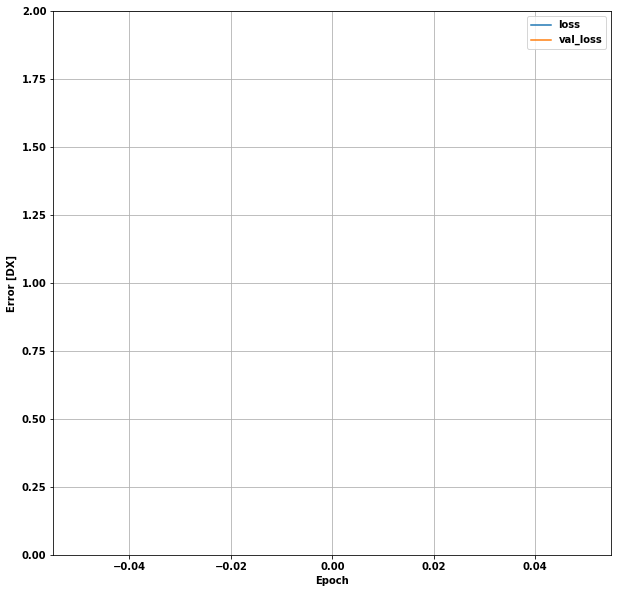

In [39]:
plot_loss(history_2)